## Scenario discovery with PRIM analysis ## 
In this notebook an open exploration is used to indicate the uncertainty values that possibly lead to required outcomes in line with the Dike rings preferences. In the first part, random policies are generated. This leads to a graph which shows the trade-off between density and coverage for the outcome `'Expected Number of Deaths'`. In the second part a specific box is explored via the inspect function and a scatterplot. This notebook ends with a part where dimensional stacking is used.

### Part 1

In [1]:
# Necessary imports in this notebook
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import prim
from ema_workbench import MultiprocessingEvaluator, ema_logging, Samplers

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import pickle

C:\Users\Marnix Verhagen\Anaconda\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(


In [2]:
# Set seed to 0 to make notebook reproducable
np.random.seed(0)

In this notebook problem formulation 2 is used because we want to explore the general trends of the model and not yet focus on Zutphen itself. During the development of this notebook different `n_scenarios` and `n_policies` variables are used to test different outcomes. Assignment 5 is used as a starting point. For the PRIM we ended up using 500 scenarios and 50 policies. 

In [3]:
model, _ = get_model_for_problem_formulation(2)

In [4]:
# Enable sampling for debugging purposes
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [5]:
n_scenarios = 500  
n_policies = 50    

In [6]:
use_pickle1 = True
# This is used to save time. Otherwise we need to re-run the MultiprocessingEvaluator every time
# It is set on False when the model for Dimensional Stacking is re-runned

if use_pickle1:
    with open('data/PRIM_results1.pickle','rb') as filehandler:
        results = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model,n_processes=10) as evaluator: #Use a logical number (cores-2) to keep your laptop useable. 
        results = evaluator.perform_experiments(n_scenarios, n_policies, uncertainty_sampling=Samplers.LHS)
    
    with open('data/PRIM_results1.pickle',"wb") as filehandler:
        pickle.dump(results,filehandler)

In [7]:
experiments, outcomes = results

In [8]:
# We drop 3 columns here which are not useful
cleaned_experiments = experiments.drop(['policy','scenario','model'],axis=1)

In [9]:
outcomesdataframe = pd.DataFrame.from_dict(outcomes)

In [10]:
outcomesdataframe.head()

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,2.736612e+06,8.062062e+08,800900000.0,188.709136,0.000160
1,8.559620e+07,8.062062e+08,800900000.0,4678.217820,0.007210
2,7.685857e+06,8.062062e+08,800900000.0,589.690134,0.001034
3,1.172449e+07,8.062062e+08,800900000.0,554.752950,0.000964
4,0.000000e+00,8.062062e+08,800900000.0,0.000000,0.000000


Dike ring 3 has a preference to minimize the flooding risk of the city of Zutphen. This is why in the open exploration we set a maximum on the Expected Number of Deaths. This outcome is the most interesting to investigate. 

In [11]:
y = (outcomes['Expected Number of Deaths'] <= 0.001) # Translates roughly 1 in 100:000 yearly chance of dike breakage

In [12]:
# PRIM is used here with the created x named cleaned_experiments and y with standard PRIM settings. 
# threshold (float) – the density threshold that a box has to meet
prim_alg = prim.Prim(cleaned_experiments,y, threshold=0.8, peel_alpha=0.05) # Default of PRIM sets peel_alpha on 0.05
box1 = prim_alg.find_box()

[MainProcess/INFO] 25000 points remaining, containing 12054 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.05376, coverage: 0.11149825783972125, density: 1.0 restricted_dimensions: 15


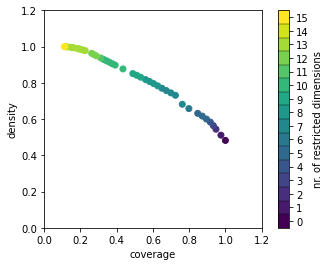

In [13]:
# Visalisation of the tradeoff between density and coverage
box1.show_tradeoff()
plt.savefig("images/PRIM_coverage_density_tradeoff.png", dpi=300, bbox_inches="tight")
plt.show()

### Part 2

In this part we inspect one of the boxes. The box chosen has to meet at least a coverage of 0.8 in combination with density which is as high as possible. Coverage > 0.8 is met in box 1 till 7. Box 7 has the highest density with 5 restricted dimensions. To make the partitioned space visible, a scatterplot is used. The red boxes indicate the partioned space of the input values that will lead to a 0.8 coverage of the desired outputs, indicated with orange dots.

coverage    0.847271
density     0.631602
id          7.000000
mass        0.646800
mean        0.631602
res_dim     5.000000
Name: 7, dtype: float64

                       box 7                                           
                         min        max                       qp values
A.5_pfail           0.099914   0.998179  [2.2627378767360804e-24, -1.0]
A.3_DikeIncrease 0  0.500000  10.000000   [6.898277463208566e-24, -1.0]
A.5_DikeIncrease 0  0.500000  10.000000    [4.57851861949132e-23, -1.0]
A.3_pfail           0.097263   0.998670    [6.11342082349435e-23, -1.0]
A.2_pfail           0.045542   0.998589  [1.2494053954778117e-06, -1.0]



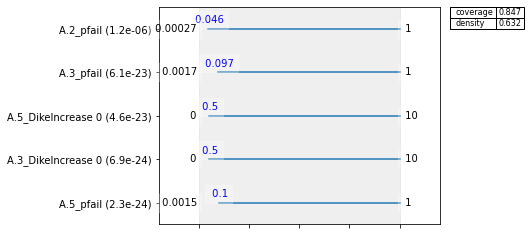

In [14]:
box1.inspect(7)  # The 8th dot seems to meet the best combination of coverage & density
box1.inspect(7, style='graph')
plt.savefig("images/PRIM_resticted_dimensions_boxes.png", dpi=300, bbox_inches="tight")
plt.show()

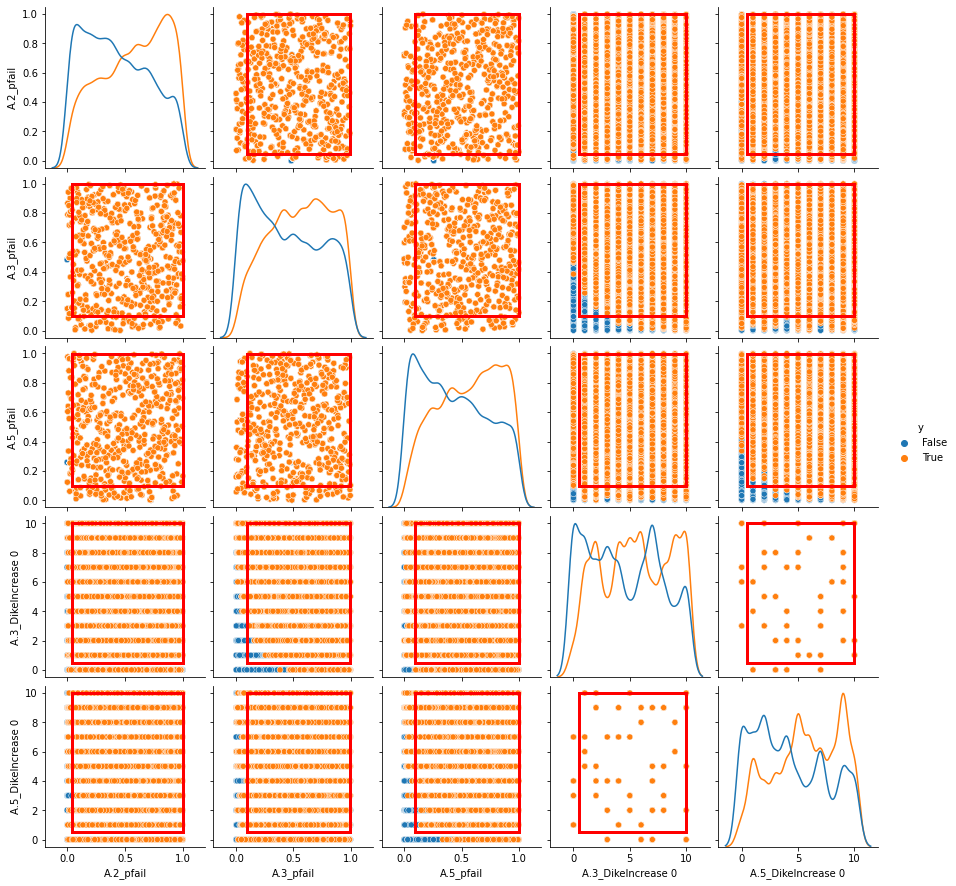

In [15]:
box1.show_pairs_scatter(7)
plt.savefig("images/PRIM_scatterplot.png", dpi=200, bbox_inches="tight")
plt.show()

### Part 3

In this part the dimensional stacking of the uncertainties is done. This module provides functionality for doing dimensional stacking of uncertain factors in order to reveal patterns in the values for a single outcome of interests. It is runned 25000 times to make sure that there are no blank spaces in the figure. 

In [16]:
#Import dimensional stacking library
from ema_workbench.analysis import dimensional_stacking

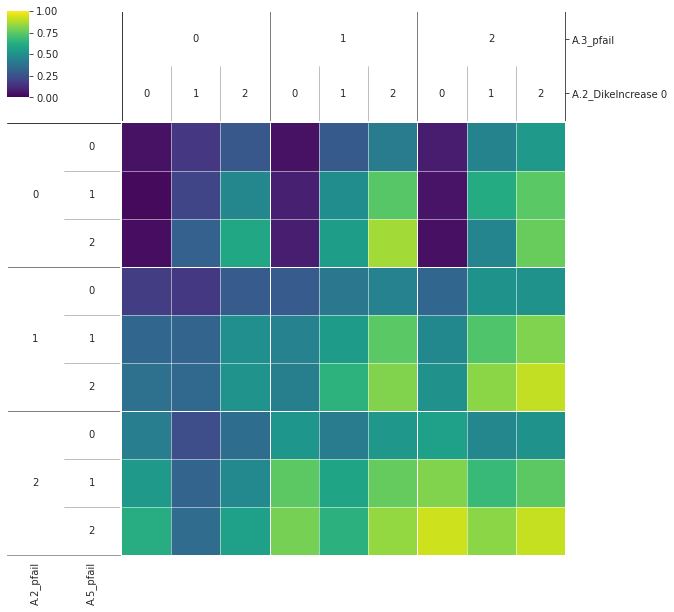

In [17]:
dimensional_stacking.create_pivot_plot(cleaned_experiments, y, nr_levels=2, labels=True, categories=True, nbins=3, bin_labels=False)
plt.savefig("images/PRIM_dimensional_stacking.png", dpi=300, bbox_inches="tight")
plt.show()